In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Dataset paths
data_dir = "/content/drive/My Drive/My_Plant_Proj/Dataset/Dataset"
train_dir = f"{data_dir}/train"
valid_dir = f"{data_dir}/valid"

In [5]:
# Image and training parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 10
MAX_PER_CLASS = 180  # Limit to 180 images per class

In [6]:
# Function to collect limited images per class
def get_limited_image_paths(directory, max_per_class=180):
    image_paths = []
    labels = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            all_images = os.listdir(class_path)
            selected_images = all_images[:max_per_class]
            for img in selected_images:
                image_paths.append(os.path.join(class_path, img))
                labels.append(class_name)
    return pd.DataFrame({"filename": image_paths, "class": labels})

In [7]:
# Create DataFrame for training & validation
train_df = get_limited_image_paths(train_dir, MAX_PER_CLASS)
valid_df = get_limited_image_paths(valid_dir, MAX_PER_CLASS)

In [9]:
# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, directory=None, x_col="filename", y_col="class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df, directory=None, x_col="filename", y_col="class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

Found 3600 validated image filenames belonging to 20 classes.
Found 3600 validated image filenames belonging to 20 classes.


In [10]:
# Get number of classes
num_classes = len(train_generator.class_indices)

In [22]:
# Define Model (DenseNet121)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Train model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=valid_generator, verbose=1)

# Save model
model.save("/content/drive/My Drive/My_Plant_Proj/Dataset/densenet121_fast.h5")

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.5252 - loss: 1.7643 - val_accuracy: 0.8694 - val_loss: 0.4230
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 579ms/step - accuracy: 0.9319 - loss: 0.2397 - val_accuracy: 0.8922 - val_loss: 0.3561
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 653ms/step - accuracy: 0.9665 - loss: 0.1509 - val_accuracy: 0.9117 - val_loss: 0.2844
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 574ms/step - accuracy: 0.9772 - loss: 0.0986 - val_accuracy: 0.9189 - val_loss: 0.2725
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 574ms/step - accuracy: 0.9810 - loss: 0.0884 - val_accuracy: 0.9219 - val_loss: 0.2493
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 585ms/step - accuracy: 0.9865 - loss: 0.0651 - val_accuracy: 0.9286 - val_loss: 0.2431
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 589ms/step - accuracy: 0.9971 - loss: 0.0378 - val_accuracy: 0.9278 - val_loss: 0.2452
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - accuracy: 0.9970 - loss: 0.0290 - val_accurac

In [1]:
# Plot Accuracy & Loss
plt.style.use("ggplot")
colors = ["#ff6361", "#bc5090", "#ffa600", "#58508d", "#003f5c", "#44bd32"]
plt.figure(figsize=(16, 10))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color=colors[0])
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', color=colors[1])
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color=colors[2])
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', color=colors[3])
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Train vs. Validation Loss Difference
plt.subplot(2, 2, 3)
loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
plt.plot(loss_diff, marker='d', color=colors[4])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title('Train vs. Validation Loss Difference', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss - Train Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

<ipython-input-17-091540726de5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


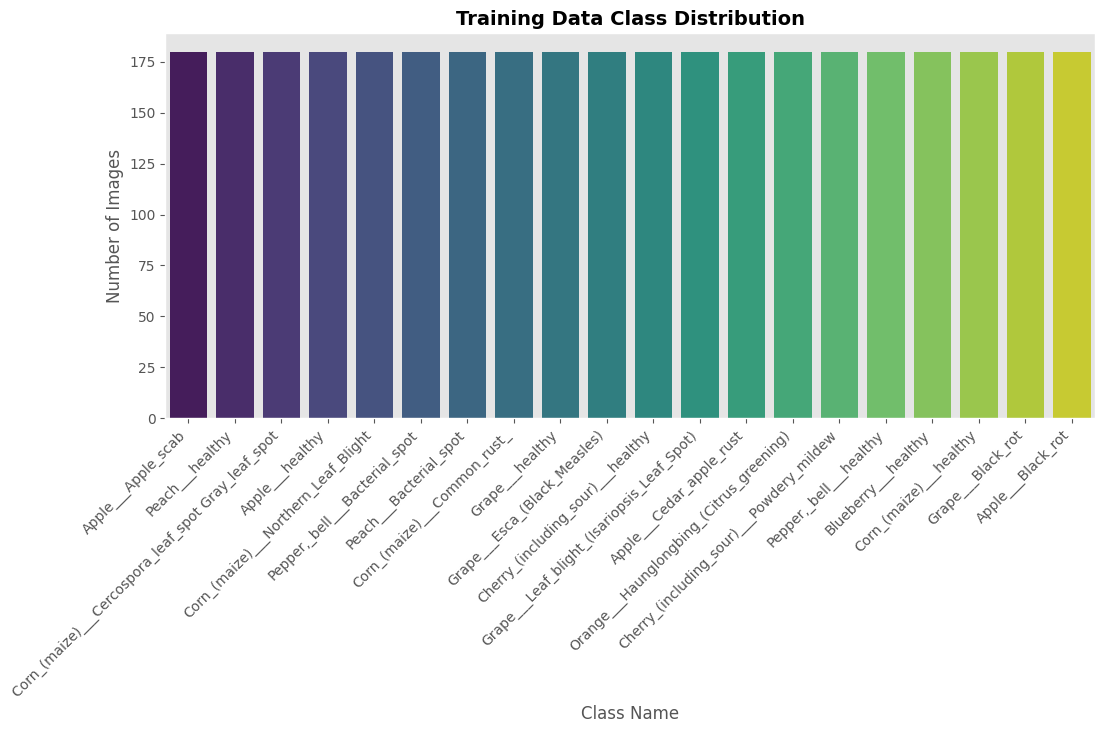

In [17]:
# Class Distribution
plt.figure(figsize=(12, 5))
class_counts = train_df['class'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Training Data Class Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 524ms/step


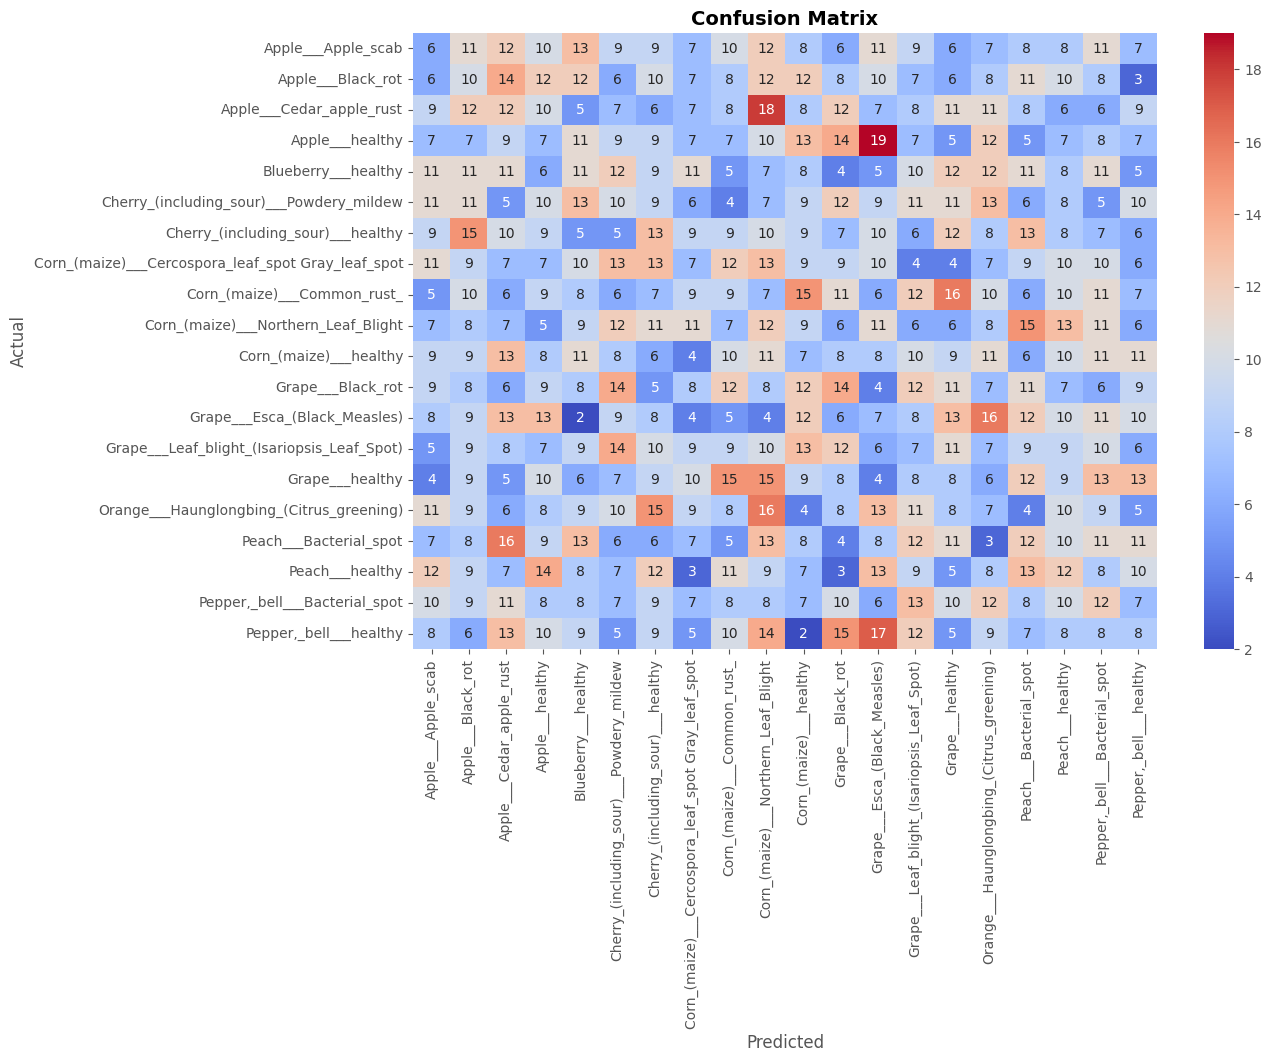

In [18]:
# Confusion Matrix
y_true = valid_generator.classes
y_pred = model.predict(valid_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()
